In [29]:
%matplotlib inline
import rosbag
import rospy
import numpy as np
from sensor_msgs.msg import Image
import matplotlib.pyplot as plt
import imageio
from moviepy.editor import ImageSequenceClip
from scipy.misc import imsave, imread
import os
from StringIO import StringIO
import tempfile
from tqdm import tqdm
import shutil
import PIL
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.font_manager

from PIL import ImageDraw, ImageFont, ImageFilter
import matplotlib as mpl

import h5py 




In [30]:
# test dataset
rosbag_fname = '../../data/2017-05-31-14-20-54.bag'
rosbag_name, _ = os.path.splitext(os.path.basename(rosbag_fname))

data_dir = '../../data'

# train data
#rosbag_fnames_to_convert = [
#    '../../data/2017-05-31-14-45-13.bag',
#    '../../data/2017-05-31-14-55-56.bag'
#]

# test data
rosbag_fnames_to_convert = [
    rosbag_fname
]

rescale_factor = 8
tmp = os.path.abspath('../tmp/')
if not os.path.exists(tmp):
    os.makedirs(tmp)
    
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [31]:
class topics:
    image = "/app/camera/rgb/image_raw/compressed"
    lights = "/manual_control/lights"
    speed = "/manual_control/speed"
    steering = "/manual_control/steering"
    stop_start = "/manual_control/stop_start"
    yaw = "/model_car/yaw"
    twist = "/motor_control/twist" 
    odom = "/odom"
    
    labels = [speed, steering, yaw]

In [32]:
def ros_jpeg_to_numpy(msg):
    if msg.format != 'rgb8; jpeg compressed bgr8':
        raise Exception("Wrong format")
    return imread(StringIO(msg.data))

def ros_jpeg_to_pil(msg):
    if msg.format != 'rgb8; jpeg compressed bgr8':
        raise Exception("Wrong format")
    return PIL.Image.open(StringIO(msg.data))

In [33]:
bag = rosbag.Bag(rosbag_fname)
bag.get_start_time()

1496240454.4035738

In [34]:
def get_time(t):
    return (1-t)*bag.get_start_time() + t*bag.get_end_time()

print(bag.get_start_time())
print(get_time(0.2))

1496240454.4
1496240494.22


In [35]:
tti = bag.get_type_and_topic_info()

fmt = "{:40}| {:30}| {:<20}"
print(fmt.format("topic", "message type", "count"))
print("-" * 80)
for name, topic in sorted(tti.topics.items()):
    print fmt.format(name, topic.msg_type, topic.message_count)

topic                                   | message type                  | count               
--------------------------------------------------------------------------------
/app/camera/rgb/image_raw/compressed    | sensor_msgs/CompressedImage   | 3590                
/manual_control/lights                  | std_msgs/String               | 1                   
/manual_control/speed                   | std_msgs/Int16                | 36                  
/manual_control/steering                | std_msgs/Int16                | 2545                
/manual_control/stop_start              | std_msgs/Int16                | 1                   
/model_car/yaw                          | std_msgs/Float32              | 19469               
/motor_control/twist                    | geometry_msgs/Twist           | 199                 
/odom                                   | nav_msgs/Odometry             | 97568               


### Get all messages for lables and convert them to pandas dataframes

In [36]:
topic_data = {t: [] for t in topics.labels}
times = {t: [] for t in topics.labels}
def parse_msg(msg, msg_type):
    
    if msg_type in ("std_msgs/Int16", "std_msgs/Float32"):
        return msg.data
    elif msg_type == 'geometry_msgs/Twist':
        return {
            msg.linear.x,
        }
    else:
        raise Exception('unknown')
        
for topic, msg, time in bag.read_messages(topics=topics.labels):
    msg_type = tti.topics[topic].msg_type
    data = parse_msg(msg, msg_type)
    times[topic].append(time.to_sec())
    topic_data[topic].append(data)

In [37]:

df = {}
for k, data in topic_data.items():
    df[k] = pd.Series(data, index=pd.DatetimeIndex(pd.to_datetime(times[k], unit='s')))

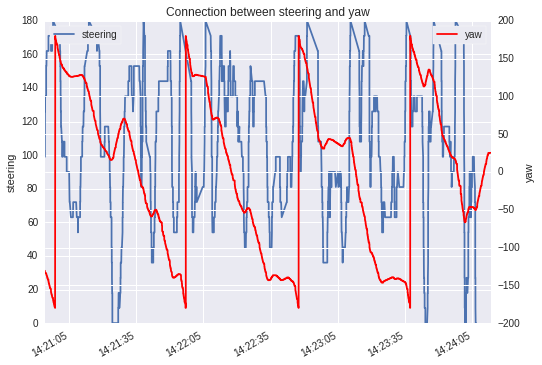

In [38]:
steering_df = df[topics.steering]
yaw_df = df[topics.yaw]

fig, ax = plt.subplots(figsize=(8, 6))
steering_df.plot(ax=ax, label='steering')
ax.set_ylabel('steering')
ax2 = ax.twinx()
yaw_df.plot(ax=ax2, color='red', label='yaw')
ax2.set_ylabel('yaw')
plt.title("Connection between steering and yaw")
ax.legend(loc='upper left', frameon=True)
ax2.legend(loc='upper right', frameon=True)
plt.show()

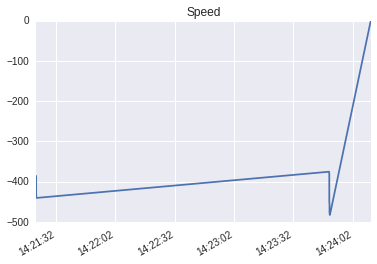

In [39]:
speed_df = df[topics.speed]
speed_df.plot(kind='line', label='speed')
plt.title("Speed")
plt.show()

In [40]:
frame_rate = tti.topics['/app/camera/rgb/image_raw/compressed'].frequency
print("Frame rate is: {:.2f}".format(frame_rate))

Frame rate is: 30.77


In [41]:
# save images as video
img_fnames = []
tmp_dir = tempfile.mkdtemp(dir=tmp)
try:
    for i, (topic, msg, time) in enumerate(tqdm(bag.read_messages(topics=[topics.image]))):
        img_fname = os.path.join(tmp_dir, "{:06d}.jpeg".format(i))
        with open(img_fname, 'wb') as f:
            f.write(msg.data)
        img_fnames.append(img_fname)

    video = ImageSequenceClip(img_fnames, fps=frame_rate, with_mask=False)
    video.write_videofile(rosbag_name + ".webm",
                          ffmpeg_params=['-b:v', '0', '-crf', '10'])
finally:
    shutil.rmtree(tmp_dir)

3590it [00:00, 7934.96it/s]


AttributeError: close

## Create a video with steering, speed, and time

In [ ]:
def command_at(df, time):
    if type(time) == rospy.rostime.Time:
        time = time.to_sec()
    dt = pd.to_datetime(time, unit='s')
    before = df[:dt]
    if len(before) != 0:
        return before[-1]
    else:
        return df[dt:][0]

def image_draw_info(img, speed, steering, time, font=None):
    if font is None:
        fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
        mono_fonts = [f for f in fonts if "mono" in f.lower() and 'bold' in f.lower()]
        mono_font = mono_fonts[0]
        font = ImageFont.truetype(mono_font, 18)
    
    draw = ImageDraw.Draw(img)

    draw.text((10, 450), time, fill="#ffffff", font=font)
    draw.text((10, 20), "steering: {}".format(steering), fill="#00ff00", font=font)
    angle = (steering) / 180. * np.pi
    x = img.size[0] / 2
    y = 100
    draw.line([x, y, x +  60*np.cos(angle), y  - 60*np.sin(angle)], fill="#00ff00", width=3)
    draw.text((10, 50), "speed: {}".format(speed), fill='#ff0000', font=font)
    del draw

    
img_fnames = []
tmp_dir = tempfile.mkdtemp(dir=tmp)

for i, (topic, msg, time) in enumerate(tqdm(
    bag.read_messages(topics=topics.image, end_time=rospy.Time(get_time(0.5))))):
    
    img_fname = os.path.join(tmp_dir, "{:06d}.png".format(i))
    img = ros_jpeg_to_numpy(msg)
    
    img = PIL.Image.fromarray(img)
    for name, d in df.items():
        value = command_at(d, time)
        
        if name == topics.steering:
            steering = value
        elif name == topics.speed:
            speed = value
    dtime = datetime.fromtimestamp(time.to_sec())
    image_draw_info(img, speed, steering, dtime.isoformat())
    img.save(img_fname)
    del img

In [ ]:
video = ImageSequenceClip(tmp_dir, fps=frame_rate, with_mask=False)
video.write_videofile(rosbag_name + "_controls.webm", ffmpeg_params=['-b:v', '0', '-crf', '20'])
shutil.rmtree(tmp_dir)

## Visualise rescaling of images

In [ ]:
def rescale_img(img):
    blur = ImageFilter.GaussianBlur(radius=rescale_factor * 1./3)
    return img.convert('L').filter(blur).resize(img_shape_pil, resample=PIL.Image.BILINEAR)
    
topic, msg, time = next(bag.read_messages(topics=topics.image))

img = ros_jpeg_to_pil(msg)
w, h = img.size
# numpy it is h, w and in the PIL world w, h
img_shape_pil = (w / rescale_factor, h / rescale_factor)
img_shape = (h / rescale_factor, w / rescale_factor)
print("rescaled image {}:".format(img_shape))
rescale_img(img)

## Create hdf5 file and convert all rosbag files

In [42]:
h5_fname = os.path.join(data_dir, 'test.hdf5')
if os.path.exists(h5_fname):
    os.remove(h5_fname)
h5 = h5py.File(h5_fname)

In [43]:
chunk = 32
h5.create_dataset('image', shape=(1, ) + img_shape, dtype='uint8',
                  maxshape=(None,) + img_shape,
                  chunks=(64,) + img_shape)
h5.create_dataset('speed', shape=(1, 1), dtype='float32', 
                  maxshape=(None, 1), chunks=(chunk, 1))
h5.create_dataset('steering', shape=(1, 1), dtype='float32', maxshape=(None, 1), chunks=(chunk, 1))
h5.create_dataset('timestamp', shape=(1, 1), dtype='float64', maxshape=(None, 1), chunks=(chunk, 1))

<HDF5 dataset "timestamp": shape (1, 1), type "<f8">

In [44]:
steering_norm = np.array([1 / 180. * np.pi, -np.pi/2])
speed_norm = np.array([1 / 500., 0])
h5['steering'].attrs['normalize'] = steering_norm
h5['speed'].attrs['normalize'] = speed_norm

In [45]:
def normalize(normalize, value):
    return np.dot(normalize, [value, 1])

i = 0
for fname in rosbag_fnames_to_convert:
    bag = rosbag.Bag(rosbag_fname)

    for topic, msg, time in tqdm(bag.read_messages(topics=topics.image)):
        for dset in h5.values():
            dset.resize(size=i+1, axis=0)

        img = ros_jpeg_to_pil(msg)
        h5['image'][i] = np.array(rescale_img(img))
        h5['speed'][i] = normalize(speed_norm, command_at(speed_df, time))
        h5['steering'][i] = normalize(steering_norm, command_at(steering_df, time))
        h5['timestamp'][i] = time.to_sec()
        i += 1

3590it [05:09, 11.61it/s]


In [46]:
print("{:10}| {:10}| {:30}".format("name", "dtype", "shape"))
print("-" * 40)
for name, dset in h5.items():
    print("{:10}| {:10}| {:30}".format(name, dset.dtype, dset.shape))

name      | dtype     | shape                         
----------------------------------------
image     | uint8     | (3590, 60, 80)                
speed     | float32   | (3590, 1)                     
steering  | float32   | (3590, 1)                     
timestamp | float64   | (3590, 1)                     


In [47]:
step = 100
images = [h5['image'][i*step] for i in range(10)]
PIL.Image.fromarray(np.concatenate(images, axis=1))

<PIL.Image.Image image mode=L size=800x60 at 0x7FEBA4E32128>

In [48]:
h5.close()